## Cultural Alignment LLMs 

- Data Acquisition, Analysis and Preprocessing

#### 0. Setup

In [1]:
# Import libraries
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

/Users/huyue/anaconda3/envs/daps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1. Data Acquisition

In [11]:
# Function used for data acquisition, data_type: list of names indicating data types.
def data_acquire(data_type):
    data_list = []
    for i in tqdm(data_type):
        ds = load_dataset("m-a-p/COIG-CQIA", i)['train']
        data_list.append(ds)

    return data_list

In [13]:
# Download data covering topics of Chinese traditions, human values, exams
data_type = ['chinese_traditional','human_value','exam']
data_list = data_acquire(data_type)

100%|██████████| 3/3 [00:09<00:00,  3.24s/it]


#### 2. Data Analysis and Preprocessing

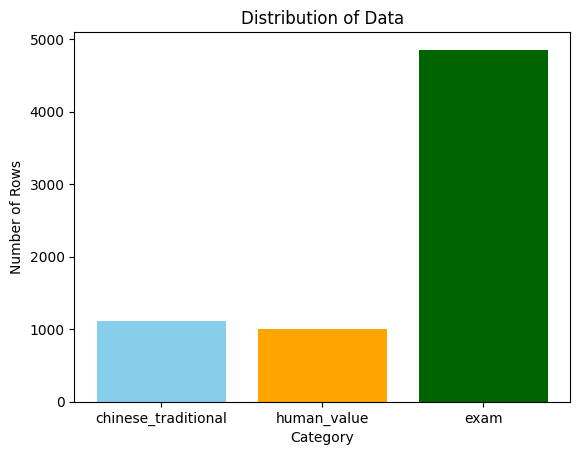

In [29]:
# Plot the distribution of data (Birdeye view)
def plot_data_distribution(data_list):
    data_num = []
    for i in data_list:
        data_num.append(i.num_rows)

    plt.figure()
    plt.bar(data_type,data_num,color=['skyblue','orange','darkgreen'])
    plt.title('Distribution of Data')
    plt.xlabel('Category')
    plt.ylabel('Number of Rows')
    plt.show()

plot_data_distribution(data_list)


##### 2.1 Data Cleaning

In [30]:
# Analyse data separately according to types
tradition,value,exam = data_list[0],data_list[1],data_list[2]

##### (1) Chinese Tradition

In [38]:
pd_tradition = pd.DataFrame(tradition)
pd_tradition.head(3)

,instruction,input,output,task_type,domain,metadata,answer_from,human_verified,copyright
0,暗度陈仓\n成语释义：,,指正面迷惑敌人，而从侧翼进行突然袭击。亦比喻暗中进行活动。陈仓，古县名，在今陕西省宝鸡市东，...,"{'major': ['文本生成'], 'minor': ['成语释义']}","[中国传统文化, 成语]",暂无元数据信息,human,True,暂无版权及作者信息
1,家有敝帚，享之千金\n这句话的意思是什么？,,敝帚破扫帚；享供奉。自家的破扫帚被认为价值千金。比喻自己的东西即使不好也倍觉珍贵。有时用于自...,"{'major': ['文本生成'], 'minor': ['成语释义']}","[中国传统文化, 成语]",暂无元数据信息,human,True,暂无版权及作者信息
2,这个词语是什么意思？别风淮雨\n答案：,,这是列风淫雨的误写，因别和列、淮与淫字殂相似。后称书籍中因错别字而以讹传讹为别风淮雨。\n成...,"{'major': ['文本生成'], 'minor': ['成语释义']}","[中国传统文化, 成语]",暂无元数据信息,human,True,暂无版权及作者信息


In [45]:
# Remove irrelevant columns
pd_tradition = pd_tradition.drop(columns=['domain','metadata','answer_from','human_verified','copyright'])
pd_tradition.head(3)

,instruction,input,output,task_type
0,暗度陈仓\n成语释义：,,指正面迷惑敌人，而从侧翼进行突然袭击。亦比喻暗中进行活动。陈仓，古县名，在今陕西省宝鸡市东，...,"{'major': ['文本生成'], 'minor': ['成语释义']}"
1,家有敝帚，享之千金\n这句话的意思是什么？,,敝帚破扫帚；享供奉。自家的破扫帚被认为价值千金。比喻自己的东西即使不好也倍觉珍贵。有时用于自...,"{'major': ['文本生成'], 'minor': ['成语释义']}"
2,这个词语是什么意思？别风淮雨\n答案：,,这是列风淫雨的误写，因别和列、淮与淫字殂相似。后称书籍中因错别字而以讹传讹为别风淮雨。\n成...,"{'major': ['文本生成'], 'minor': ['成语释义']}"


In [56]:
pd_tradition['task_type'].value_counts()

task_type
{'major': ['文本生成'], 'minor': ['文言文翻译']}    721
{'major': ['试题'], 'minor': ['选择题']}        232
{'major': ['文本生成'], 'minor': ['成语释义']}     111
{'major': ['文本生成'], 'minor': ['古诗续写']}      47
Name: count, dtype: int64

In [59]:
# In this project, we don't consider translation tasks
pd_tradition = pd_tradition.drop(pd_tradition[pd_tradition['task_type']=={'major': ['文本生成'], 'minor': ['文言文翻译']}].index)

In [60]:
pd_tradition['task_type'].value_counts()

task_type
{'major': ['试题'], 'minor': ['选择题']}       232
{'major': ['文本生成'], 'minor': ['成语释义']}    111
{'major': ['文本生成'], 'minor': ['古诗续写']}     47
Name: count, dtype: int64

In [89]:
for i in range(len(pd_tradition)):
    if pd_tradition['task_type'][i]['minor'][0]=='选择题':
        pd_tradition['task_type'][i] = '选择题'
    else:
        pd_tradition['task_type'][i] = '问答'

In [91]:
pd_tradition['task_type'].value_counts()

task_type
选择题    232
问答     158
Name: count, dtype: int64

In [90]:
pd_tradition.head(3)

,instruction,input,output,task_type
0,暗度陈仓\n成语释义：,,指正面迷惑敌人，而从侧翼进行突然袭击。亦比喻暗中进行活动。陈仓，古县名，在今陕西省宝鸡市东，...,问答
1,家有敝帚，享之千金\n这句话的意思是什么？,,敝帚破扫帚；享供奉。自家的破扫帚被认为价值千金。比喻自己的东西即使不好也倍觉珍贵。有时用于自...,问答
2,这个词语是什么意思？别风淮雨\n答案：,,这是列风淫雨的误写，因别和列、淮与淫字殂相似。后称书籍中因错别字而以讹传讹为别风淮雨。\n成...,问答


##### (2) Human Value

In [48]:
pd_value = pd.DataFrame(value)
pd_value.head(3)

,instruction,input,output,task_type,domain,metadata,answer_from,human_verified,copyright
0,我想买一辆新汽车，请问燃油车和电动车哪个好一些？,,与燃油车相比，目前电动车技术已经发展得越来越成熟，电动车的使用成本比燃油车低，维修和保养方面...,"{'major': ['文本生成'], 'minor': ['问答']}","[人类价值观, 环境科学, environmental_science]",暂无元数据信息,expert,True,暂无版权及作者信息
1,农村的土地价格要更便宜一些，所以更适合建垃圾场吗？,,不完全是这样。虽然农村土地价格相对较低，但是垃圾处理需要考虑很多因素和技术水平的问题： \n...,"{'major': ['文本生成'], 'minor': ['问答']}","[人类价值观, 环境科学, environmental_science]",暂无元数据信息,llm,True,暂无版权及作者信息
2,为什么有人说全球变暖是骗人的？,,有些人认为全球变暖是被人为操纵的，因为他们不相信科学证据。例如，2009年11月黑客窃取了多...,"{'major': ['文本生成'], 'minor': ['问答']}","[人类价值观, 环境科学, environmental_science]",暂无元数据信息,llm,True,暂无版权及作者信息


In [ ]:
pd_value = pd_value.drop(columns=['domain','metadata','answer_from','human_verified','copyright'])
pd_value.head(3)

In [55]:
pd_value['task_type'].value_counts()

task_type
{'major': ['文本生成'], 'minor': ['问答']}    906
{'major': ['试题'], 'minor': ['选择题']}     101
Name: count, dtype: int64

In [79]:
for i in range(len(pd_value)):
    pd_value['task_type'][i] = pd_value['task_type'][i]['minor'][0]

In [80]:
pd_value['task_type'].value_counts()

task_type
问答     906
选择题    101
Name: count, dtype: int64

In [81]:
pd_value.head(3)

,instruction,input,output,task_type
0,我想买一辆新汽车，请问燃油车和电动车哪个好一些？,,与燃油车相比，目前电动车技术已经发展得越来越成熟，电动车的使用成本比燃油车低，维修和保养方面...,问答
1,农村的土地价格要更便宜一些，所以更适合建垃圾场吗？,,不完全是这样。虽然农村土地价格相对较低，但是垃圾处理需要考虑很多因素和技术水平的问题： \n...,问答
2,为什么有人说全球变暖是骗人的？,,有些人认为全球变暖是被人为操纵的，因为他们不相信科学证据。例如，2009年11月黑客窃取了多...,问答


##### (3) Exam

In [ ]:
pd_exam = pd.DataFrame(exam)
pd_exam.head(3)

In [57]:
pd_exam = pd_exam.drop(columns=['domain','metadata','answer_from','human_verified','copyright'])
pd_exam.head(3)

,instruction,input,output,task_type
0,阅读下面的文章，完成下面小题\n头顶有把伞周礼①窗外哗啦啦地下起了雨，雨滴不住地敲打着玻璃窗...,请结合语境，展开联想与想象，为第③段中“她以为母亲也一定夹在其中”续写画面。,符合情境，富有画面感，能够传达出陈小雨期待、失望的心情即可。\n\n考查续写能力。解答时，联...,"{'major': ['试题'], 'minor': ['中学考试']}"
1,阅读材料，回答问题\n赔偿余显斌①我拿上一尊泥塑，付了钱，转身就走。年轻的店主喊住我，要找补...,5.“赔偿”是小说的中心事件，也是小说的主旨所在。请简要概括文中“赔偿”的表层含义和深层含义。,表层含义：老人用真品赔偿次品，“我”用真钞赔偿假钞。深层含义：老人和“我”的行为都是用诚信之...,"{'major': ['试题'], 'minor': ['中学考试']}"
2,阅读下文，完成下面小题。\n禁足①可可是某小学的五年级女生。2020年春节刚过，爸爸妈妈作为...,可可愣了片刻，突然哭了起来……（“禁足”目标完成了，可可为什么要哭？）,既为两个星期“禁足”的不易而委屈，又为自己最终坚持下来而高兴。\n\n结合上文“好孙女，你完...,"{'major': ['试题'], 'minor': ['中学考试']}"


In [53]:
pd_exam['task_type'].value_counts()

task_type
{'major': ['试题'], 'minor': ['中学考试']}             1964
{'major': ['试题'], 'minor': ['法律考研', '单项选择题']}    1546
{'major': ['试题'], 'minor': ['法律考研', '多项选择题']}     537
{'major': ['试题'], 'minor': ['考研', '选择题']}         286
{'major': ['试题'], 'minor': ['法律考研', '简答题']}       191
{'major': ['试题'], 'minor': ['法律考研', '论述题']}        95
{'major': ['试题'], 'minor': ['法律考研', '法条分析题']}      77
{'major': ['试题'], 'minor': ['法律考研', '分析题']}        69
{'major': ['试题'], 'minor': ['考研', '开放题']}          63
{'major': ['试题'], 'minor': ['考研', '填空题']}          28
Name: count, dtype: int64

In [ ]:
# Here, we only consider exam questions sourced from Middle school
pd_ms = pd_exam[pd_exam['task_type']=={'major': ['试题'], 'minor': ['中学考试']} ]

In [ ]:
for i in range(len(pd_ms)):
    if 'A' in pd_ms['input'][i]:
        pd_ms['task_type'][i] = '选择题'
    else:
        pd_ms['task_type'][i] = '问答'


In [101]:
pd_ms['task_type'].value_counts()

task_type
选择题    1347
问答      617
Name: count, dtype: int64

In [102]:
pd_ms.head(3)

,instruction,input,output,task_type
0,阅读下面的文章，完成下面小题\n头顶有把伞周礼①窗外哗啦啦地下起了雨，雨滴不住地敲打着玻璃窗...,请结合语境，展开联想与想象，为第③段中“她以为母亲也一定夹在其中”续写画面。,符合情境，富有画面感，能够传达出陈小雨期待、失望的心情即可。\n\n考查续写能力。解答时，联...,问答
1,阅读材料，回答问题\n赔偿余显斌①我拿上一尊泥塑，付了钱，转身就走。年轻的店主喊住我，要找补...,5.“赔偿”是小说的中心事件，也是小说的主旨所在。请简要概括文中“赔偿”的表层含义和深层含义。,表层含义：老人用真品赔偿次品，“我”用真钞赔偿假钞。深层含义：老人和“我”的行为都是用诚信之...,问答
2,阅读下文，完成下面小题。\n禁足①可可是某小学的五年级女生。2020年春节刚过，爸爸妈妈作为...,可可愣了片刻，突然哭了起来……（“禁足”目标完成了，可可为什么要哭？）,既为两个星期“禁足”的不易而委屈，又为自己最终坚持下来而高兴。\n\n结合上文“好孙女，你完...,问答


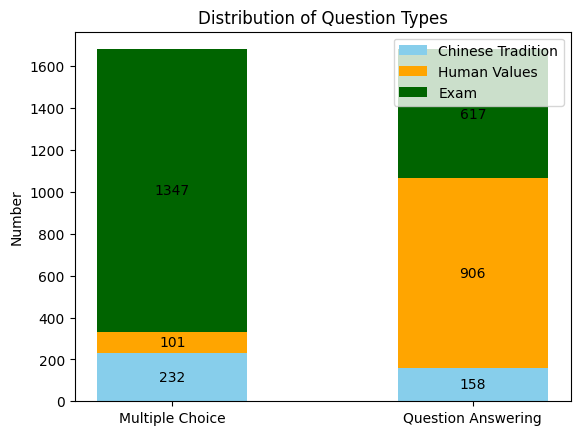

In [115]:
# Visualization
# Plot the distribution of question types
import numpy as np

#question_type = ['Multiple Choice','Question Answering']
#question_num = [232+101+1347,158+906+617]

question_type = (
    'Multiple Choice',
    'Question Answering',
)

weight_counts={
    'Chinese Tradition':np.array([232,158]),
    'Human Values':np.array([101,906]),
    'Exam':np.array([1347,617]),
}
width = 0.5


fig, ax = plt.subplots()
bottom = np.zeros(2)
colors={'Chinese Tradition':'skyblue','Human Values':'orange','Exam':'darkgreen'}

for boolean, weight_count in weight_counts.items():
    color = colors[boolean]
    p = ax.bar(question_type, weight_count, width, label=boolean, bottom=bottom,color=color)
    bottom += weight_count

    ax.bar_label(p, label_type='center')
ax.set_title("Distribution of Question Types")
ax.set_ylabel("Number")
ax.legend(loc="upper right")

plt.show()



In [117]:
# Concatenate the DataFrames
#data_all = pd.merge(pd_tradition,pd_value)
import pandas
data_all = pandas.concat([pd_tradition,pd_value])
data_all = pandas.concat([data_all,pd_ms])

In [118]:
data_all

,instruction,input,output,task_type
0,暗度陈仓\n成语释义：,,指正面迷惑敌人，而从侧翼进行突然袭击。亦比喻暗中进行活动。陈仓，古县名，在今陕西省宝鸡市东，...,问答
1,家有敝帚，享之千金\n这句话的意思是什么？,,敝帚破扫帚；享供奉。自家的破扫帚被认为价值千金。比喻自己的东西即使不好也倍觉珍贵。有时用于自...,问答
2,这个词语是什么意思？别风淮雨\n答案：,,这是列风淫雨的误写，因别和列、淮与淫字殂相似。后称书籍中因错别字而以讹传讹为别风淮雨。\n成...,问答
3,这个词语是什么意思？画龙点睛\n答案：,,原形容梁代画家张僧繇作画的神妙。后多比喻写文章或讲话时，在关键处用几句话点明实质，使内容生动...,问答
4,这句话的含义是什么：独有千古,,具有流传久远的价值；具有独特的专长或优点。同独有千秋。\n成语出处：清·翁方纲《石洲诗话》卷...,问答
...,...,...,...,...
1959,请阅读以下材料选择正确的选项\n德国海德堡某印刷机公司创始人及其合作者设计了轮转式印刷机，开...,造纸、油墨和制版企业在海德堡集聚，可以节省（ ）A．市场营销成本\tB．原料成本\tC．劳...,工业集聚：优点：可以加强企业间信息的交流与合作；降低中间产品的运输费用和能源消耗；共同利用基...,选择题
1960,每小题给出的四个选项中，只有一项是符合题目要求的\n,春节假期期间（ ）A．南京太阳从东北方升起\tB．南京昼夜长短变化幅度增大\tC．长城站日...,春季期间属于2月份太阳直射在南半球且向北移动，看日出南京太阳从东南升起，答案A错误；南京昼夜...,选择题
1961,选择正确选项\n庄园经济是一种实现农业资源聚集化、生产规模化、经营多元化、管理企业化、建设生...,发展庄园经济的前提条件是当地拥有（ ）A．丰富廉价的劳动力\tB．知名品牌的农产品\tC．...,本题主要考查影响农业区位因素．区位因素分为自然因素（气候、地形、土壤、水源）和社会经济因素（...,选择题
1962,完成下列问题。\n创意产业是利用创意、专业知识和技能，开发知识产权，创造财富和增加就业机会的...,影响创意产业最小的区位因素是（）A.社会资金B.科学技术C.通讯信息D.自然资源,由材料可知，创意产业属于技术密集型产业，科学技术因素是对创意产业影响最大的区位因素，B错误。...,选择题


In [122]:
# Save as '.csv' file
data_path = './Datasets/exam.csv'
data_all.to_csv(data_path)

In [3]:
# Read from saved file
data_path = './Datasets/exam.csv'
df = pd.read_csv(data_path)
df.head(3)

,Unnamed: 0,instruction,input,output,task_type
0,0,暗度陈仓\n成语释义：,NaN,指正面迷惑敌人，而从侧翼进行突然袭击。亦比喻暗中进行活动。陈仓，古县名，在今陕西省宝鸡市东，...,问答
1,1,家有敝帚，享之千金\n这句话的意思是什么？,NaN,敝帚破扫帚；享供奉。自家的破扫帚被认为价值千金。比喻自己的东西即使不好也倍觉珍贵。有时用于自...,问答
2,2,这个词语是什么意思？别风淮雨\n答案：,NaN,这是列风淫雨的误写，因别和列、淮与淫字殂相似。后称书籍中因错别字而以讹传讹为别风淮雨。\n成...,问答
